# UK Gambling and TNL projections

Sources

ONS - Family spending:Detailed expenditure and trends - https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/expenditure/datasets/familyspendingworkbook1detailedexpenditureandtrends

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('white')
%matplotlib inline

In [2]:
econ_df = pd.DataFrame()
gambling_df = pd.DataFrame()
tnl_df = pd.DataFrame()

In [3]:
temp = pd.read_csv('./Source Data/ABMI-290920.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','GDP']

temp['GDP'] = pd.to_numeric(temp['GDP'])
temp['year'] = pd.to_numeric(temp['year'])
#temp['GDP growth'] = temp['GDP'].pct_change()

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [4]:
temp = pd.read_csv('./Source Data/QWND-290920.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','disposable income']

temp['disposable income'] = pd.to_numeric(temp['disposable income'])
temp['year'] = pd.to_numeric(temp['year'])
#temp['disposable income growth'] = temp['disposable income'].pct_change()

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [5]:
temp = pd.read_csv('./Source Data/familyspending.csv')

number_households = temp.iloc[8].iloc[4:24].drop(temp.columns[9]).drop(temp.columns[18])
number_households = pd.to_numeric(number_households.str.replace(",",""))

temp.drop(temp.columns[2:4].union(temp.columns[9:10]).union(temp.columns[18:19]).union(temp.columns[24:]), axis=1, inplace = True)
temp.drop(temp.index[0:5].union(temp.index[6:19]).union(temp.index[42:47]).union(temp.index[48:]).union(temp.index[20:41:2]),axis=0,inplace = True)
temp.drop(temp.columns[0],axis=1,inplace=True)

temp['Unnamed: 1'].iloc[0]='0'
temp.columns = pd.to_numeric(temp.iloc[0].str.slice(start=0,stop=4))
temp.drop(temp.index[0],axis=0,inplace=True)

temp = temp.transpose()
temp.columns = temp.iloc[0]
temp.drop(temp.index[0],axis=0,inplace=True)

temp[temp.columns] = temp[temp.columns].apply(pd.to_numeric, errors='coerce')

# Convert from spend per household into total spend in the UK per year
number_households.index = temp.index
temp[temp.columns] = temp[temp.columns].apply(lambda x: (x*number_households*52*1000)/1000000)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)


In [6]:
temp = pd.read_csv('./Source Data/marketdata.csv')
temp.index = temp['Year']
temp = temp.drop('Year',axis=1)

econ_df = econ_df.merge(
    temp[[
        'UK Adult Population',
        'Online sales as % of total UK retail sales',
        '% of population that participated in online shopping']].loc[:2019],
    left_index=True,
    right_index=True,
    how='outer'
)

gambling_df = pd.concat(
    [gambling_df,
     temp[[
        'Gambling GGY',
        'Gambling GGY - In Person',
        'Gambling GGY - Online',
        'Total gambling participation',
        'Gambling (ex. TNL) participation',
        'Agree that gambling is conducted fairly and can be trusted - All respondents',
        'Agree that gambling is conducted fairly and can be trusted - Gambled in the last 12 months',
        'Agree that gambling is conducted fairly and can be trusted - Not gambled in the last 12 months']].loc[:2019]
    ]
)

gambling_df['GGY per player'] = gambling_df['Gambling GGY'] / gambling_df['Total gambling participation']

tnl_df = pd.concat(
    [tnl_df,
     temp[['TNL GGY',
           'TNL participation']].loc[:2019]
    ]
)

In [7]:
econ_df.columns = [
    'GDP', 
    'disposable income', 
    'food',
    'alcohol, tobacco & narcotics',
    'clothing & footwear',
    'housing, fuel & power',
    'household goods & services',
    'health',
    'transport',
    'communication',
    'recreation',
    'education',
    'restaurants & hotels',
    'miscellaneous goods & services',
    'other',
    'UK adult population',
    'online sales %',
    '% pop shopped online']
gambling_df.columns = [
    'gambling GGY',
    'gambling GGY - In Person', 
    'gambling GGY - Online',
    'gambling players',
    'gambling players ex TNL',
    'trust gambling',
    'trust gambling - players',
    'trust gambling - non players',
    'GGY per player']
tnl_df.columns = [
    'TNL GGY', 
    'TNL players']

In [8]:
econ_df['disposable income pc'] = econ_df['disposable income'] / econ_df['UK adult population']

In [9]:
df = pd.DataFrame()
df = pd.merge(
        econ_df,
        gambling_df,
        left_index=True,
        right_index=True,
        how='outer',
)

df = pd.merge(
        df,
        tnl_df,
        left_index=True,
        right_index=True,
        how='outer',
)

df.index = df.index.set_names('year')

# Gambling Market - Montecarlo Simulation

##### Model


                 |- Population                             : Historical mean/std
     |- Players -x
     |           |- Participation %                        : 0.377 + 0.666 * trust(%)
     |
     |
GGY -x                                       |- Disp. Inc. : -1080040 + 1.222 * GDP 
     |                    |- Disp. Inc. p/c -/
     |                    |                  |- Population : Historical mean/std
     |- Spend per player -x
                          |
                          |- % for gambling                : Historical mean/std

In [53]:
iterations = 4000
override_GDP = True

In [54]:
initial_year = 2020
initial_GDP = df.loc[2019]['GDP']
initial_population = df.loc[2019]['UK adult population']
initial_trust = df.loc[2019]['trust gambling']
initial_disp_share = (df.loc[2019]['GGY per player'] / df.loc[2019]['disposable income pc'])
initial_TNL_share = (df.loc[2019]['TNL GGY'] / df.loc[2019]['gambling GGY'])

In [55]:
years_to_project = 9
projected_years = np.arange(initial_year,initial_year+years_to_project)

In [56]:
# Set distribution for model inputs
GDP_mean = 0.024384                #Historical average of YoY growth in the period from 1956 to 2019
GDP_std_dev = 0.020191             #Historical stdev of YoY growth in the period from 1956 to 2019

GDP_override_mean  = [-0.09714035,0.06687500]    # Consensus of 40 analysts estimating UK GDP for 2020 and 2021 @ September 2020
GDP_override_std_dev = [0.01523440,0.01583329]   # Consensus of 40 analysts estimating UK GDP for 2020 and 2021 @ September 2020


population_mean = 0.007
population_std_dev  = 0.002774

trust_mean = -0.051647             #Historical average of YoY growth in the period from 2010 to 2019
trust_std_dev = 0.053116           #Historical stdev of YoY growth in the period from 2010 to 2019

disp_share_mean = -0.007
disp_share_std_dev = 0.05312       #Historical stdev of YoY growth in the period from 2008 to 2019

TNL_share_mean = 0.00868           #Historical average of YoY growth in the period from 2008 to 2019
TNL_share_std_dev = 0.10146        #Historical stdev of YoY growth in the period from 2008 to 2019

In [57]:
res_df = pd.DataFrame(columns=['Year','GDP','GDP Growth','Population', 'Population Growth', 'Trust','Trust Growth', 'Share Disp Income','Share Disp Income Growth', 'TNL share','TNL share Growth'])
for n in range(iterations):
    projected_GDP_growth = np.random.normal(GDP_mean, GDP_std_dev, years_to_project)
    projected_population_growth = np.random.normal(population_mean, population_std_dev, years_to_project)
    projected_trust_growth = np.random.normal(trust_mean, trust_std_dev, years_to_project)
    projected_disp_share_growth = np.random.normal(disp_share_mean, disp_share_std_dev, years_to_project)
    projected_TNL_share_growth = np.random.normal(TNL_share_mean, TNL_share_std_dev, years_to_project)    
    
    if override_GDP:
        for i,mean in enumerate(GDP_override_mean):
            projected_GDP_growth[i] = np.random.normal(mean, GDP_override_std_dev[i])
    
    proj_df = pd.DataFrame(columns=['Year','GDP','GDP Growth','Population', 'Population Growth', 'Trust','Trust Growth', 'Share Disp Income','Share Disp Income Growth', 'TNL share','TNL share Growth'])
    
    proj_df['Year'] = projected_years
    proj_df['GDP'] = 1
    proj_df['Population'] = 1
    proj_df['Trust'] = 1
    proj_df['Share Disp Income'] = 1
    proj_df['TNL Share'] = 1
    
    proj_df['GDP Growth'] = projected_GDP_growth
    proj_df['Population Growth'] = projected_population_growth    
    proj_df['Trust Growth'] = projected_trust_growth
    proj_df['Share Disp Income Growth'] = projected_disp_share_growth
    proj_df['TNL Share Growth'] = projected_TNL_share_growth
    
    gdp_growth_factor = proj_df['GDP Growth'] + 1
    population_growth_factor = proj_df['Population Growth'] + 1
    trust_growth_factor = proj_df['Trust Growth'] + 1
    disp_share_growth_factor = proj_df['Share Disp Income Growth'] + 1
    TNL_share_growth_factor = proj_df['TNL Share Growth'] + 1    
    
    for i in range(years_to_project):
        proj_df['GDP'] = proj_df['GDP'] * gdp_growth_factor.shift(i,fill_value=1)
        proj_df['Population'] = proj_df['Population'] * population_growth_factor.shift(i,fill_value=1)
        proj_df['Trust'] = proj_df['Trust'] * trust_growth_factor.shift(i,fill_value=1)
        proj_df['Share Disp Income'] = proj_df['Share Disp Income'] * disp_share_growth_factor.shift(i,fill_value=1)
        proj_df['TNL Share'] = proj_df['TNL Share'] * TNL_share_growth_factor.shift(i,fill_value=1)    
        
    proj_df['GDP'] *= initial_GDP
    proj_df['Population'] *= initial_population
    proj_df['Trust'] *= initial_trust
    proj_df['Share Disp Income'] *= initial_disp_share
    proj_df['TNL Share'] *= initial_TNL_share    
    

    proj_df['Disp Inc'] = (-1080040 + (proj_df['GDP'] * 1.222))
    proj_df['Disp Inc pc'] = proj_df['Disp Inc'] / proj_df['Population']
    proj_df['GGY per player'] = proj_df['Disp Inc pc'] * proj_df['Share Disp Income']
    proj_df['Participation'] = (0.377 + (proj_df['Trust'] * 0.666))
    proj_df['Players'] = proj_df['Population'] * proj_df['Participation']
    proj_df['GGY'] = proj_df['Players'] * proj_df['GGY per player']
    proj_df['TNL'] = proj_df['GGY'] * proj_df['TNL Share']
    
    res_df = pd.concat([proj_df,res_df])

In [58]:
hist_df = df.loc[2008:2019][[
        'GDP',
        'disposable income',
        'disposable income pc',
        'UK adult population',
        'gambling GGY',
        'gambling players',
        'GGY per player',    
        'trust gambling',
        'TNL GGY']]

In [59]:
hist_df['share disposable income pc'] = hist_df['GGY per player'] / hist_df['disposable income pc']
hist_df['TNL share'] = hist_df['TNL GGY'] / hist_df['gambling GGY']
hist_df['type'] = 'Historic'

In [60]:
proj_df = res_df[[
    'GDP',
    'Disp Inc',
    'Disp Inc pc',
    'Population',
    'GGY',
    'Players',
    'GGY per player',
    'Trust',
    'TNL',
    'Share Disp Income',
    'TNL Share']]

In [61]:
proj_df['type'] = 'Projection'
proj_df.index = res_df['Year']
proj_df.columns = hist_df.columns


/home/alvaroaguilar/.venvs/gambling_market/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
full_df = pd.concat([hist_df,proj_df])

### Exec Summary

- Public trust in gambling has eroded signigifcantly. Only 29% now agree that gamling is conducted fairly and can be trusted vs. 50% in 2009
- In that period the industry has aggressively expanded mental and physical availability managing to maintain and sligthly grow its share of disposable income between 2010 and 2017
- But the erosion of trust has damaged participation and growth has been driven by the spend of a reducing number of players. The portion of disposable income that the average player dedicates to gambling activities grew from 1.2% in 2010 to 1.8% in 2017
- Concentrating the revenue on a smaller set of players has in turn increased the risk in the industry and that has materialised in public pressure and regulatory action
- The National Lottery was slower in pulling the physial and mental availability levers that allowed the rest of industry to growAnd as a result it lost 9 p.p. of market share between 2010 and 2017
- In the last two years TNL has increased its mental and physical availability and has started recovering share in the market


- The physical and mental availability levers that allowed gambling to maintain growth despite consumer perception headwinds are running out of steam and growth has started to stagnate
- In that context would expect the industry to grow at a rate between 0.3% and 4.0% per year between 2019 and 2027


- TNL is less exposed to that risk but with no action we would expect ###
- Our plan is to isolate TNL from that risk while increasing its appeal for consumers' that don't participate in gambling and we believe that will allow TNL to grow its share of recreation and leisure spend

#### Public trust in gambling has eroded signigifcantly. Only 29% now agree that gamling is conducted fairly and can be trusted vs. 50% in 2009

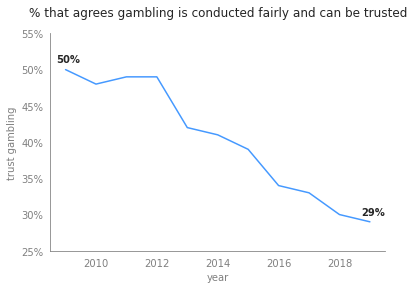

In [63]:
title = '% that agrees gambling is conducted fairly and can be trusted'

ax = sns.lineplot(x=df.loc[2009:].index,
                  y=df.loc[2009:]['trust gambling'],
                  color="#4599ff")

plt.text(x = 2008.7, y = df.loc[2009]['trust gambling']*1.02, s = '{:.0%}'.format(df.loc[2009]['trust gambling']),fontweight='bold')
plt.text(x = 2018.7, y = df.loc[2019]['trust gambling']*1.03, s = '{:.0%}'.format(df.loc[2019]['trust gambling']),fontweight='bold')

label_format = '{:,.0%}'
ax.set_yticks(ax.get_yticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_yticklabels([label_format.format(x) for x in ax.get_yticks().tolist()])

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

plt.title(title,y=1.05)

sns.despine()

#### Trust in gambling is consistently very low amongst non players and players trust has deteriorated significantly in the last ten years

[Text(2007.5, 0, '8'),
 Text(2010.0, 0, '10'),
 Text(2012.5, 0, '12'),
 Text(2015.0, 0, '15'),
 Text(2017.5, 0, '18'),
 Text(2020.0, 0, '20')]

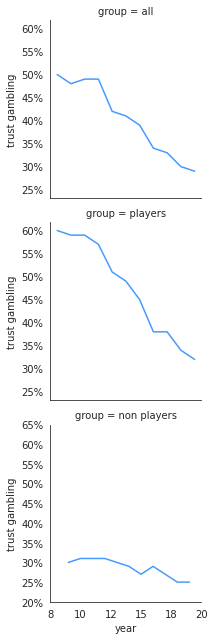

In [64]:
tmp = pd.DataFrame(df.loc[2008:]['trust gambling'], index=df.loc[2008:].index)
tmp['year'] = df.loc[2008:].index
tmp['group'] = 'all'
tmp2 = pd.DataFrame(df.loc[2008:]['trust gambling - players'], index=df.loc[2008:].index)
tmp2['year'] = df.loc[2008:].index
tmp2['group'] = 'players'
tmp3 = pd.DataFrame(df.loc[2008:]['trust gambling - non players'], index=df.loc[2008:].index)
tmp3['year'] = df.loc[2008:].index
tmp3['group'] = 'non players'

tmp2.columns=tmp.columns
tmp3.columns=tmp.columns

X = pd.concat([tmp,tmp2,tmp3])

g = sns.FacetGrid(X, row="group")
g.map(sns.lineplot, "year", "trust gambling",color="#4599ff")

ax = g.axes.flat[2]
label_format = '{:,.0%}'
ax.set_yticks(ax.get_yticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_yticklabels([label_format.format(x) for x in ax.get_yticks().tolist()])

label_format = '{:,.0f}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()-2000).tolist()])



#### The industry has managed to grow despite eroding trust by aggressively expanding mental and physical availability

*Insert slide with advertising growing, number of outlets growing and digital expansion*


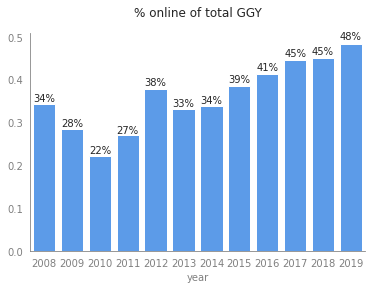

In [65]:
title = '% online of total GGY'

ax = sns.barplot(x=df.loc[2008:].index,
                 y=(df.loc[2008:]['gambling GGY - Online'] / df.loc[2008:]['gambling GGY']),
                 color="#4599ff")
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = 1.02 * height,
            s = '{:.0%}'.format(height),
            ha = 'center')
ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')    
    
plt.title(title,y=1.05)

sns.despine()


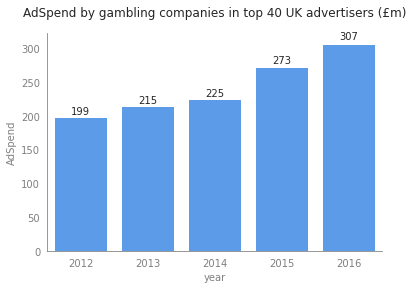

In [66]:
title = 'AdSpend by gambling companies in top 40 UK advertisers (£m)'

tt = pd.DataFrame({'AdSpend':[199,215,225,273,307],
                   'year':[2012,2013,2014,2015,2016]})

ax = sns.barplot(x=tt['year'],
                 y=tt['AdSpend'],
                 color="#4599ff")

for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = 1.02 * height,
            s = '{:.0f}'.format(height),
            ha = 'center')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')    
    
plt.title(title,y=1.05)

sns.despine()



#### Through physical and mental availability gambling has managed to maintain and sligthly grow its share of disposable income between 2010 and 2017

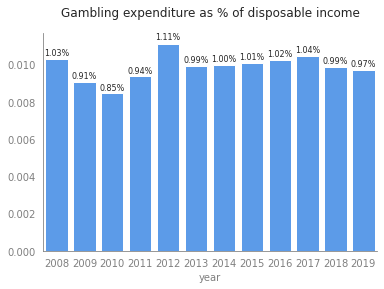

In [67]:
title = 'Gambling expenditure as % of disposable income'

ax = sns.barplot(x=df.loc[2008:].index,
                 y=(df.loc[2008:]['gambling GGY'] / df.loc[2008:]['disposable income']),
                 color="#4599ff")

sns.despine(right=True,left=True)
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = 1.02 * height,
            s = '{:.2%}'.format(height),
            ha = 'center',
            fontsize=8)
    
ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')    
    
plt.title(title,y=1.05)

sns.despine()

#### But the erosion of trust has damaged participation and growth has been achieved by increasing the portion of disposable income that player dedicate to gambling activities from 1.2% in 2010 to 1.8% in 2017

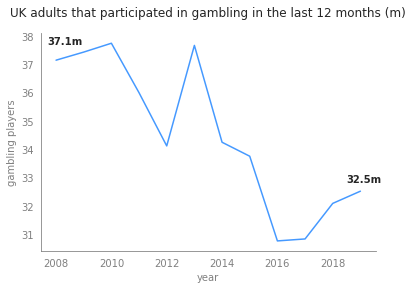

In [68]:
title = 'UK adults that participated in gambling in the last 12 months (m)'

ax = sns.lineplot(x=df.loc[2008:].index,
             y=df.loc[2008:]['gambling players'],
             color="#4599ff")

plt.text(x = 2007.7, y = df.loc[2008]['gambling players']*1.015, s = '{:.1f}m'.format(df.loc[2008]['gambling players']),fontweight='bold')
plt.text(x = 2018.5, y = df.loc[2019]['gambling players']*1.01, s = '{:.1f}m'.format(df.loc[2019]['gambling players']),fontweight='bold')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

plt.title(title,y=1.05)

sns.despine()

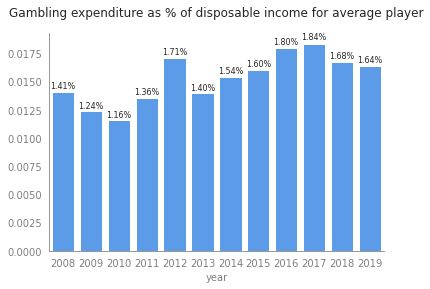

In [69]:
title = "Gambling expenditure as % of disposable income for average player"

ax = sns.barplot(x=df.loc[2008:].index,
            y=(df.loc[2008:]['GGY per player'] / df.loc[2008:]['disposable income pc']),
            color="#4599ff")

sns.despine(right=True,left=True)
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = 1.02 * height,
            s = '{:.2%}'.format(height),
            ha = 'center',
            fontsize=8)

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

plt.title(title,y=1.05)

sns.despine()

#### Concentrating the revenue on a smaller set of players has in turn increased the risk in the industry and that has materialised in public pressure and regulatory action

*Insert slide showing increasing number of players at risk and timeline of news*

#### The National Lottery was slower in pulling the physial and mental availability levers that allowed the rest of industry to grow ...

*Insert slide showing marketing budget and digital playership between 2008 and 2019*

#### ... and as a result it lost 9 p.p. of market share between 2010 and 2017

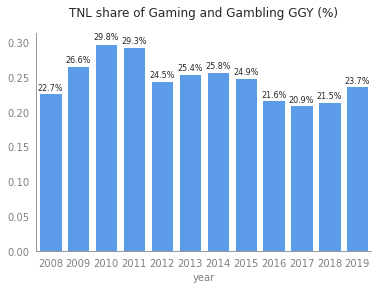

In [70]:
title = "TNL share of Gaming and Gambling GGY (%)"

ax = sns.barplot(x=df.loc[2008:2019].index,
            y=df.loc[2008:2019]['TNL GGY'] / df.loc[2008:2019]['gambling GGY'],
            color="#4599ff"
           )

for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = 1.02 * height,
            s = '{:.1%}'.format(height),
            ha = 'center',
            fontsize=8)
    
ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

plt.title(title,y=1.05)

sns.despine()

#### In the last two years TNL has increased its mental and physical availability and has started recovering share in the market

*Insert slide that shows increases in marketing and digital playership in the last three years*

#### With the traditional levers running out of steam and public trust headwinds growth in Gaming and Gambling has started to stagnate - Our projections consider recovery and worsening scenarios -

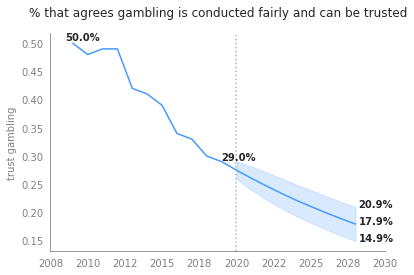

In [71]:
title = '% that agrees gambling is conducted fairly and can be trusted'                  

m = full_df.loc[2028]['trust gambling'].mean()
sd = full_df.loc[2028]['trust gambling'].std()

ax = sns.lineplot(data=full_df,x=full_df.index,y="trust gambling",ci="sd",color="#4599ff")

plt.text(x = 2008.5, y = full_df.loc[2009]['trust gambling']*1.01, s = '{:.1%}'.format(full_df.loc[2009]['trust gambling']),fontweight='bold')
plt.text(x = 2019, y = full_df.loc[2019]['trust gambling']*1.01, s = '{:.1%}'.format(full_df.loc[2019]['trust gambling']),fontweight='bold')
plt.text(x = 2028.2, y = (m), s = '{:.1%}'.format(m),fontweight='bold')
plt.text(x = 2028.2, y = (m-sd), s = '{:.1%}'.format(m-sd),fontweight='bold')
plt.text(x = 2028.2, y = (m+sd), s = '{:.1%}'.format(m+sd),fontweight='bold')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:.0f}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])

ax.axvline(2020, ls='dotted', color="0.7")

plt.title(title,y=1.05)

sns.despine()

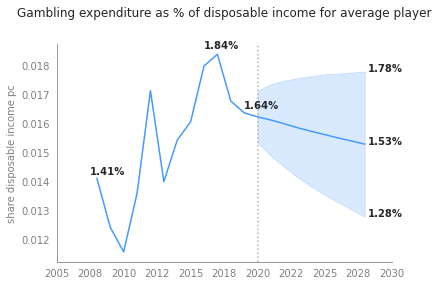

In [72]:
title = "Gambling expenditure as % of disposable income for average player"

m = full_df.loc[2028]['share disposable income pc'].mean()
sd = full_df.loc[2028]['share disposable income pc'].std()

ax = sns.lineplot(data=full_df,x=full_df.index,y="share disposable income pc",ci="sd",color="#4599ff")

plt.text(x = 2007.5, y = full_df.loc[2008]['share disposable income pc']*1.01, s = '{:.2%}'.format(full_df.loc[2008]['share disposable income pc']),fontweight='bold')
plt.text(x = 2016, y = full_df.loc[2017]['share disposable income pc']*1.01, s = '{:.2%}'.format(full_df.loc[2017]['share disposable income pc']),fontweight='bold')
plt.text(x = 2019, y = full_df.loc[2019]['share disposable income pc']*1.01, s = '{:.2%}'.format(full_df.loc[2019]['share disposable income pc']),fontweight='bold')
plt.text(x = 2028.2, y = (m), s = '{:.2%}'.format(m),fontweight='bold')
plt.text(x = 2028.2, y = (m-sd), s = '{:.2%}'.format(m-sd),fontweight='bold')
plt.text(x = 2028.2, y = (m+sd), s = '{:.2%}'.format(m+sd),fontweight='bold')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:.0f}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])

ax.axvline(2020, ls='dotted', color="0.7")

plt.title(title,y=1.1)

sns.despine()

#### In that context would expect the industry to grow at a rate between -0.6% and 3.8% per year between 2019 and 2028

In [73]:
def cagr(initial,final,periods):
    return ((final/initial)**(1/periods))-1

#print('{:.1%}'.format((full_df.loc[2027]['gambling GGY'].quantile(0.15) / full_df.loc[2019]['gambling GGY'].mean())-1))
#print('{:.1%}'.format((full_df.loc[2027]['gambling GGY'].quantile(0.85) / full_df.loc[2019]['gambling GGY'].mean())-1))

c_min = cagr(
    full_df.loc[2019]['gambling GGY'].mean(),
    full_df.loc[2028]['gambling GGY'].quantile(0.15),
    2027-2019)

c_max = cagr(
    full_df.loc[2019]['gambling GGY'].mean(),
    full_df.loc[2028]['gambling GGY'].quantile(0.85),
    2028-2019)

print('There is 70% probability that CAGR 19-27 will be between: {:.1%} and {:.1%}'.format(c_min,c_max))

There is 70% probability that CAGR 19-27 will be between: -3.1% and 1.6%


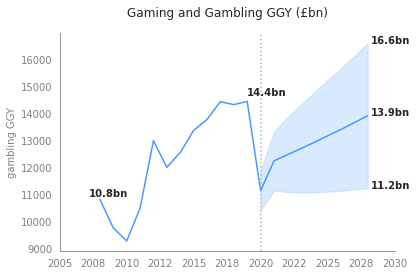

In [74]:
title = "Gaming and Gambling GGY (£bn)"

m = full_df.loc[2028]['gambling GGY'].mean()
sd = full_df.loc[2028]['gambling GGY'].std()

ax = sns.lineplot(data=full_df,x=full_df.index,y="gambling GGY",ci="sd",color="#4599ff")

plt.text(x = 2007.2, y = full_df.loc[2008]['gambling GGY']*1.01, s = '{:.1f}bn'.format(full_df.loc[2008]['gambling GGY']/1000),fontweight='bold')
plt.text(x = 2019, y = full_df.loc[2019]['gambling GGY']*1.015, s = '{:.1f}bn'.format(full_df.loc[2019]['gambling GGY']/1000),fontweight='bold')
plt.text(x = 2028.2, y = (m), s = '{:.1f}bn'.format(m/1000),fontweight='bold')
plt.text(x = 2028.2, y = (m-sd), s = '{:.1f}bn'.format((m-sd)/1000),fontweight='bold')
plt.text(x = 2028.2, y = (m+sd), s = '{:.1f}bn'.format((m+sd)/1000),fontweight='bold')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:.0f}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])

ax.axvline(2020, ls='dotted', color="0.7")

plt.title(title,y=1.05)

sns.despine()

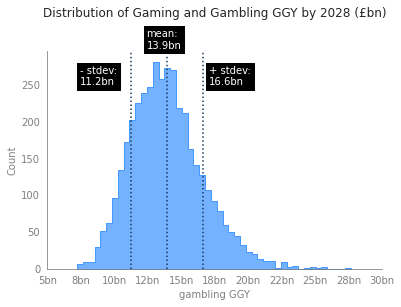

In [75]:
title = "Distribution of Gaming and Gambling GGY by 2028 (£bn)"

m = full_df.loc[2028]['gambling GGY'].mean()
sd = full_df.loc[2028]['gambling GGY'].std()

ax = sns.histplot(data=full_df.loc[2028],
                x="gambling GGY",
                color="#4599ff",
                element="step")

#maximum = max([h.get_height() for h in ax.patches])

plt.axvline(m, color="#173559", ls='dotted')
plt.text(x = m-1500,
         y = 300, # y-coordinate position of data label, to take max height 
         s = 'mean:\n{:.1f}bn'.format(m/1000), # data label
         color = "white",
         bbox=dict(facecolor='black'))

plt.axvline(m-sd, color="#173559", ls='dotted')
plt.text(x = m-sd-3800, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 250, # y-coordinate position of data label, to take max height 
         s = '- stdev:\n{:.1f}bn'.format((m-sd)/1000), # data label
         color = "white",
         bbox=dict(facecolor='black'))

plt.axvline(m+sd, color="#173559", ls='dotted')
plt.text(x = m+sd+500, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 250, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = '+ stdev:\n{:.1f}bn'.format((m+sd)/1000), # data label
         color = "white",
         bbox=dict(facecolor='black'))

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:,.0f}bn'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()/1000).tolist()])

plt.title(title,y=1.13)

sns.despine()

#### If TNL market share behaves in line with the 2008-2019 period its GGY could grow between -3.3% and 5.5% per year

In [76]:
def cagr(initial,final,periods):
    return ((final/initial)**(1/periods))-1

#print('{:.1%}'.format((full_df.loc[2027]['gambling GGY'].quantile(0.15) / full_df.loc[2019]['gambling GGY'].mean())-1))
#print('{:.1%}'.format((full_df.loc[2027]['gambling GGY'].quantile(0.85) / full_df.loc[2019]['gambling GGY'].mean())-1))

c_min = cagr(
    full_df.loc[2019]['TNL GGY'].mean(),
    full_df.loc[2028]['TNL GGY'].quantile(0.15),
    2027-2019)

c_max = cagr(
    full_df.loc[2019]['TNL GGY'].mean(),
    full_df.loc[2028]['TNL GGY'].quantile(0.85),
    2028-2019)

print('There is 70% probability that CAGR 19-28 will be between: {:.1%} and {:.1%}'.format(c_min,c_max))

There is 70% probability that CAGR 19-28 will be between: -4.9% and 3.9%


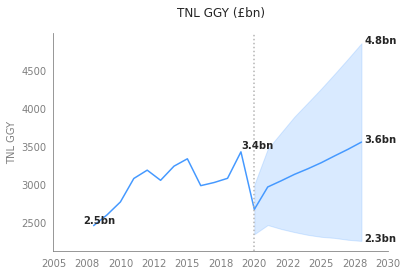

In [77]:
title = "TNL GGY (£bn)"

m = full_df.loc[2028]['TNL GGY'].mean()
sd = full_df.loc[2028]['TNL GGY'].std()

ax = sns.lineplot(data=full_df,x=full_df.index,y='TNL GGY',ci="sd",color="#4599ff")

plt.text(x = 2007.2, y = full_df.loc[2008]['TNL GGY']*1.01, s = '{:.1f}bn'.format(full_df.loc[2008]['TNL GGY']/1000),fontweight='bold')
plt.text(x = 2019, y = full_df.loc[2019]['TNL GGY']*1.015, s = '{:.1f}bn'.format(full_df.loc[2019]['TNL GGY']/1000),fontweight='bold')
plt.text(x = 2028.2, y = (m), s = '{:.1f}bn'.format(m/1000),fontweight='bold')
plt.text(x = 2028.2, y = (m-sd), s = '{:.1f}bn'.format((m-sd)/1000),fontweight='bold')
plt.text(x = 2028.2, y = (m+sd), s = '{:.1f}bn'.format((m+sd)/1000),fontweight='bold')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:.0f}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])

plt.title(title,y=1.05)

ax.axvline(2020, ls='dotted', color="0.7")

sns.despine()

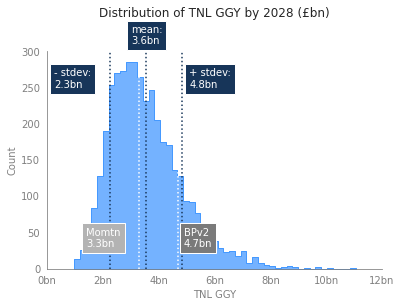

In [78]:
title = "Distribution of TNL GGY by 2028 (£bn)"

m = full_df.loc[2028]['TNL GGY'].mean()
sd = full_df.loc[2028]['TNL GGY'].std()

breakeven = 3128      # GGY to breakeven in 2028 with BPv2 assumptions
momentum = 3300
bpv2 = 4700

ax = sns.histplot(data=full_df.loc[2028],
                x="TNL GGY",
                color="#4599ff",
                element="step")

plt.axvline(m, color="#173559", ls='dotted')
plt.text(x = m-550,
         y = 310,
         s = 'mean:\n{:.1f}bn'.format(m/1000), # data label
         color = "white",
         bbox=dict(facecolor='#173559'))

plt.axvline(m-sd, color="#173559", ls='dotted')
plt.text(x = m-sd-2000, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 250, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = '- stdev:\n{:.1f}bn'.format((m-sd)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#173559'))

plt.axvline(m+sd, color="#173559", ls='dotted')
plt.text(x = m+sd+250, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 250, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = '+ stdev:\n{:.1f}bn'.format((m+sd)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#173559'))

plt.axvline(momentum, color="white", ls='dotted')
plt.text(x = momentum-1900, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 30, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = 'Momtn\n{:.1f}bn'.format((momentum)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#b3b3b3'))

plt.axvline(bpv2, color="white", ls='dotted')
plt.text(x = bpv2+200, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 30, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = 'BPv2\n{:.1f}bn'.format((bpv2)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#7a7a7a'))


ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:,.0f}bn'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()/1000).tolist()])


plt.title(title,y=1.13)

sns.despine()

/home/alvaroaguilar/.venvs/gambling_market/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


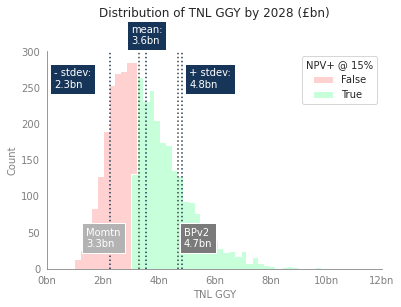

In [79]:
title = "Distribution of TNL GGY by 2028 (£bn)"

m = full_df.loc[2028]['TNL GGY'].mean()
sd = full_df.loc[2028]['TNL GGY'].std()

breakeven = 3128      # GGY to breakeven in 2028 with BPv2 assumptions
momentum = 3300
bpv2 = 4700
colors = ["#ffc2c2", "#b3ffce"]
df_to_plot = full_df.loc[2028]
df_to_plot['NPV+ @ 15%'] = df_to_plot['TNL GGY'] > breakeven

ax = sns.histplot(data=df_to_plot, multiple="stack",
                hue = "NPV+ @ 15%", palette=sns.color_palette(colors),
#ax = sns.histplot(data=full_df.loc[2028],
                x="TNL GGY",
                color="#4599ff",
                element="step")


plt.axvline(m, color="#173559", ls='dotted')
plt.text(x = m-550,
         y = 310,
         s = 'mean:\n{:.1f}bn'.format(m/1000), # data label
         color = "white",
         bbox=dict(facecolor='#173559'))

plt.axvline(m-sd, color="#173559", ls='dotted')
plt.text(x = m-sd-2000, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 250, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = '- stdev:\n{:.1f}bn'.format((m-sd)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#173559'))

plt.axvline(m+sd, color="#173559", ls='dotted')
plt.text(x = m+sd+250, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 250, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = '+ stdev:\n{:.1f}bn'.format((m+sd)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#173559'))

plt.axvline(momentum, color="0.25", ls='dotted')
plt.text(x = momentum-1900, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 30, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = 'Momtn\n{:.1f}bn'.format((momentum)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#b3b3b3'))

plt.axvline(bpv2, color="0.25", ls='dotted')
plt.text(x = bpv2+200, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 30, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = 'BPv2\n{:.1f}bn'.format((bpv2)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#7a7a7a'))

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:,.0f}bn'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()/1000).tolist()])


plt.title(title,y=1.13)

sns.despine()

/home/alvaroaguilar/.venvs/gambling_market/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


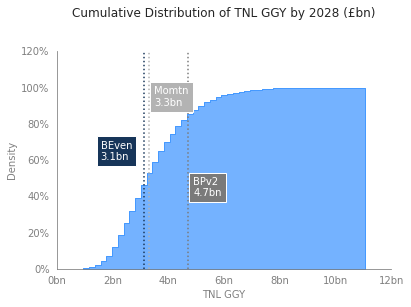

In [80]:
title = "Cumulative Distribution of TNL GGY by 2028 (£bn)"

m = full_df.loc[2028]['TNL GGY'].mean()
sd = full_df.loc[2028]['TNL GGY'].std()

breakeven = 3128      # GGY to breakeven in 2028 with BPv2 assumptions
momentum = 3300
bpv2 = 4700
colors = ["#ffc2c2", "#b3ffce"]
df_to_plot = full_df.loc[2028]
df_to_plot['NPV+ @ 15%'] = df_to_plot['TNL GGY'] > breakeven

ax = sns.histplot(data=df_to_plot, multiple="stack",
#                hue = "NPV+ @ 15%", palette=sns.color_palette(colors),
#ax = sns.histplot(data=full_df.loc[2028],
                x="TNL GGY",
                color="#4599ff",
                element="step",
                stat="density",
                cumulative=True)

plt.axvline(breakeven, color="#173559", ls='dotted')
plt.text(x = breakeven-1550, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 0.6, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = 'BEven\n{:.1f}bn'.format((breakeven)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#173559'))

plt.axvline(momentum, color="#b3b3b3", ls='dotted')
plt.text(x = momentum+200, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 0.9, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = 'Momtn\n{:.1f}bn'.format((momentum)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#b3b3b3'))

plt.axvline(bpv2, color="#7a7a7a", ls='dotted')
plt.text(x = bpv2+200, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 0.4, #max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
         s = 'BPv2\n{:.1f}bn'.format((bpv2)/1000), # data label
         color = "white",
         bbox=dict(facecolor='#7a7a7a'))

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:,.0f}bn'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()/1000).tolist()])

label_format = '{:,.0%}'
ax.set_yticks(ax.get_yticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_yticklabels([label_format.format(x) for x in (ax.get_yticks()).tolist()])


plt.title(title,y=1.13)

sns.despine()

## Appendix - Inputs in the gambling industry projections

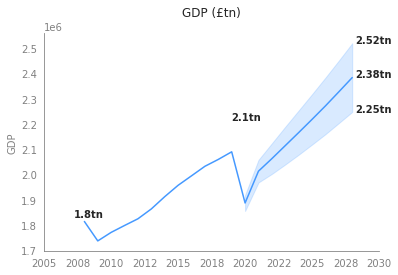

In [81]:
title = "GDP (£tn)"

m = full_df.loc[2028]['GDP'].mean()
sd = full_df.loc[2028]['GDP'].std()

ax = sns.lineplot(data=full_df,x=full_df.index,y="GDP",ci="sd",color="#4599ff")

plt.text(x = 2007.2, y = full_df.loc[2008]['GDP']*1.01, s = '{:.1f}tn'.format(full_df.loc[2008]['GDP']/1000000),fontweight='bold')
plt.text(x = 2019, y = full_df.loc[2019]['GDP']*1.06, s = '{:.1f}tn'.format(full_df.loc[2019]['GDP']/1000000),fontweight='bold')
plt.text(x = 2028.2, y = (m), s = '{:.2f}tn'.format(m/1000000),fontweight='bold')
plt.text(x = 2028.2, y = (m-sd), s = '{:.2f}tn'.format((m-sd)/1000000),fontweight='bold')
plt.text(x = 2028.2, y = (m+sd), s = '{:.2f}tn'.format((m+sd)/1000000),fontweight='bold')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:.0f}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])

plt.title(title,y=1.05)

sns.despine()

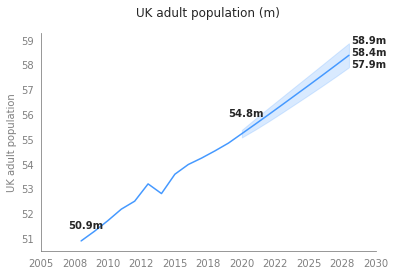

In [82]:
title = "UK adult population (m)"

m = full_df.loc[2028]['UK adult population'].mean()
sd = full_df.loc[2028]['UK adult population'].std()

ax = sns.lineplot(data=full_df,x=full_df.index,y="UK adult population",ci="sd",color="#4599ff")
plt.text(x = 2007, y = full_df.loc[2008]['UK adult population']*1.01, s = '{:.1f}m'.format(full_df.loc[2008]['UK adult population']),fontweight='bold')
plt.text(x = 2019, y = full_df.loc[2019]['UK adult population']*1.02, s = '{:.1f}m'.format(full_df.loc[2019]['UK adult population']),fontweight='bold')
plt.text(x = 2028.2, y = (m), s = '{:.1f}m'.format(m),fontweight='bold')
plt.text(x = 2028.2, y = (m-sd), s = '{:.1f}m'.format((m-sd)),fontweight='bold')
plt.text(x = 2028.2, y = (m+sd), s = '{:.1f}m'.format((m+sd)),fontweight='bold')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:.0f}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])

plt.title(title,y=1.05)

sns.despine()

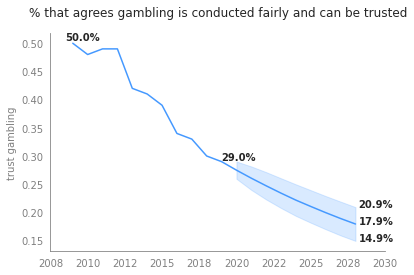

In [83]:
title = '% that agrees gambling is conducted fairly and can be trusted'                  

m = full_df.loc[2028]['trust gambling'].mean()
sd = full_df.loc[2028]['trust gambling'].std()

ax = sns.lineplot(data=full_df,x=full_df.index,y="trust gambling",ci="sd",color="#4599ff")

plt.text(x = 2008.5, y = full_df.loc[2009]['trust gambling']*1.01, s = '{:.1%}'.format(full_df.loc[2009]['trust gambling']),fontweight='bold')
plt.text(x = 2019, y = full_df.loc[2019]['trust gambling']*1.01, s = '{:.1%}'.format(full_df.loc[2019]['trust gambling']),fontweight='bold')
plt.text(x = 2028.2, y = (m), s = '{:.1%}'.format(m),fontweight='bold')
plt.text(x = 2028.2, y = (m-sd), s = '{:.1%}'.format(m-sd),fontweight='bold')
plt.text(x = 2028.2, y = (m+sd), s = '{:.1%}'.format(m+sd),fontweight='bold')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:.0f}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])


plt.title(title,y=1.05)

sns.despine()

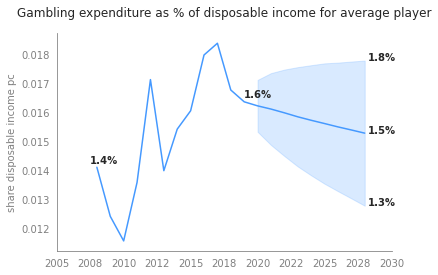

In [84]:
title = "Gambling expenditure as % of disposable income for average player"

m = full_df.loc[2028]['share disposable income pc'].mean()
sd = full_df.loc[2028]['share disposable income pc'].std()

ax = sns.lineplot(data=full_df,x=full_df.index,y="share disposable income pc",ci="sd",color="#4599ff")

plt.text(x = 2007.5, y = full_df.loc[2008]['share disposable income pc']*1.01, s = '{:.1%}'.format(full_df.loc[2008]['share disposable income pc']),fontweight='bold')
plt.text(x = 2019, y = full_df.loc[2019]['share disposable income pc']*1.01, s = '{:.1%}'.format(full_df.loc[2019]['share disposable income pc']),fontweight='bold')
plt.text(x = 2028.2, y = (m), s = '{:.1%}'.format(m),fontweight='bold')
plt.text(x = 2028.2, y = (m-sd), s = '{:.1%}'.format(m-sd),fontweight='bold')
plt.text(x = 2028.2, y = (m+sd), s = '{:.1%}'.format(m+sd),fontweight='bold')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:.0f}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])

plt.title(title,y=1.05)

sns.despine()

In [85]:
full_df.columns

Index(['GDP', 'disposable income', 'disposable income pc',
       'UK adult population', 'gambling GGY', 'gambling players',
       'GGY per player', 'trust gambling', 'TNL GGY',
       'share disposable income pc', 'TNL share', 'type'],
      dtype='object')

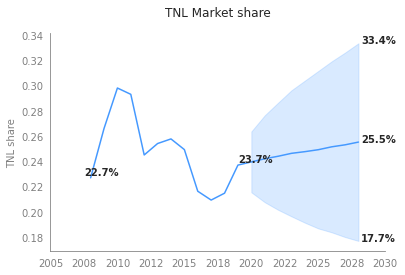

In [86]:
title = "TNL Market share"

m = full_df.loc[2028]['TNL share'].mean()
sd = full_df.loc[2028]['TNL share'].std()

ax = sns.lineplot(data=full_df,x=full_df.index,y="TNL share",ci="sd",color="#4599ff")

plt.text(x = 2007.5, y = full_df.loc[2008]['TNL share']*1.01, s = '{:.1%}'.format(full_df.loc[2008]['TNL share']),fontweight='bold')
plt.text(x = 2019, y = full_df.loc[2019]['TNL share']*1.01, s = '{:.1%}'.format(full_df.loc[2019]['TNL share']),fontweight='bold')
plt.text(x = 2028.2, y = (m), s = '{:.1%}'.format(m),fontweight='bold')
plt.text(x = 2028.2, y = (m-sd), s = '{:.1%}'.format(m-sd),fontweight='bold')
plt.text(x = 2028.2, y = (m+sd), s = '{:.1%}'.format(m+sd),fontweight='bold')

ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:.0f}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])

plt.title(title,y=1.05)

sns.despine()

## Appendix 2 - Historical behaviour of projection inputs

count    6400.0%
mean        2.4%
std         2.0%
min        -4.2%
25%         1.7%
50%         2.5%
75%         3.5%
max         6.5%
Name: GDP, dtype: object

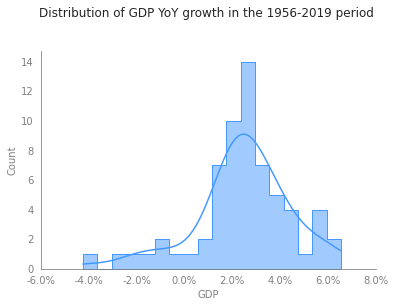

In [90]:
title = "Distribution of GDP YoY growth in the 1956-2019 period "

ax = sns.histplot(x=df['GDP'].pct_change(),
                  binwidth=0.006, 
                  kde=True,
                  color="#4599ff",
                  element="step")


ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:,.1%}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])


plt.title(title,y=1.13)

sns.despine()    
df['GDP'].pct_change().describe().apply("{0:.1%}".format)

count    1000.0%
mean       -5.2%
std         5.3%
min       -14.3%
25%        -8.0%
50%        -3.7%
75%        -2.5%
max         2.1%
Name: trust gambling, dtype: object

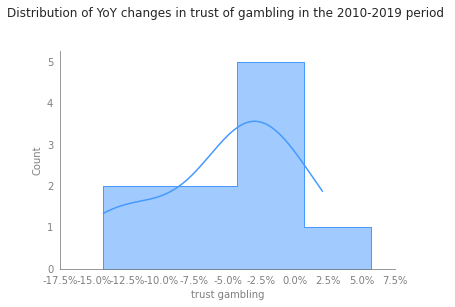

In [91]:
title = "Distribution of YoY changes in trust of gambling in the 2010-2019 period "

ax = sns.histplot(x=df['trust gambling'].pct_change(),
                  binwidth=0.05, 
                  kde=True,
                  color="#4599ff",
                  element="step")


ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:,.1%}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])


plt.title(title,y=1.13)

sns.despine()    

df['trust gambling'].pct_change().describe().apply("{0:.1%}".format)

count    1100.0%
mean        2.1%
std        13.4%
min       -18.3%
25%        -7.8%
50%         2.2%
75%        11.1%
max        26.0%
dtype: object

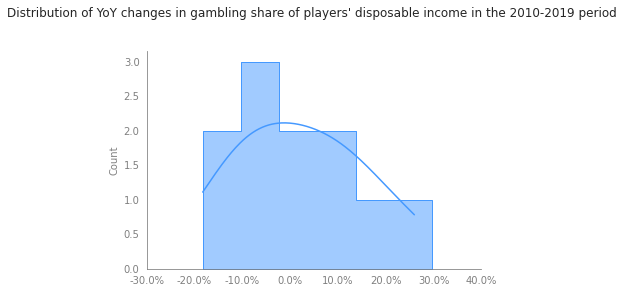

In [92]:
share_disp_inc = df['GGY per player'] / (df['disposable income']/df['UK adult population'])

title = "Distribution of YoY changes in gambling share of players' disposable income in the 2010-2019 period "

ax = sns.histplot(x=share_disp_inc.pct_change(),
                  binwidth=0.08,
                  kde=True,
                  color="#4599ff",
                  element="step")


ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:,.1%}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])


plt.title(title,y=1.13)

sns.despine()    

share_disp_inc.pct_change().describe().apply("{0:.1%}".format)

In [93]:
df.columns

Index(['GDP', 'disposable income', 'food', 'alcohol, tobacco & narcotics',
       'clothing & footwear', 'housing, fuel & power',
       'household goods & services', 'health', 'transport', 'communication',
       'recreation', 'education', 'restaurants & hotels',
       'miscellaneous goods & services', 'other', 'UK adult population',
       'online sales %', '% pop shopped online', 'disposable income pc',
       'gambling GGY', 'gambling GGY - In Person', 'gambling GGY - Online',
       'gambling players', 'gambling players ex TNL', 'trust gambling',
       'trust gambling - players', 'trust gambling - non players',
       'GGY per player', 'TNL GGY', 'TNL players'],
      dtype='object')

count    11.00000
mean      0.00868
std       0.10146
min      -0.16375
25%      -0.03252
50%       0.01436
75%       0.07021
max       0.17198
dtype: object

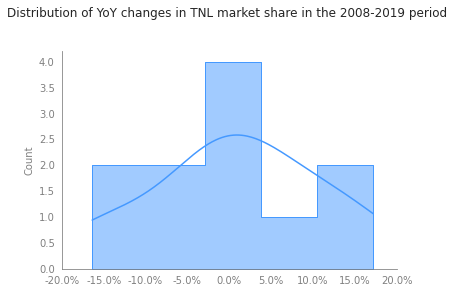

In [94]:
TNL_share = df['TNL GGY'] / df['gambling GGY']

title = "Distribution of YoY changes in TNL market share in the 2008-2019 period "

ax = sns.histplot(x=TNL_share.pct_change(),
                  kde=True,
                  color="#4599ff",
                  element="step")


ax.spines['bottom'].set_color("grey")
ax.xaxis.label.set_color("grey")
ax.tick_params(axis='x', colors='grey')

ax.spines['left'].set_color("grey")
ax.yaxis.label.set_color("grey")
ax.tick_params(axis='y', colors='grey')

label_format = '{:,.1%}'
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
ax.set_xticklabels([label_format.format(x) for x in (ax.get_xticks()).tolist()])


plt.title(title,y=1.13)

sns.despine()    

TNL_share.pct_change().describe().apply("{0:.5f}".format)

## Aux

In [ ]:
##Percentage that all the categories presented represent of total disposable income

econ_df.drop(['GDP','GDP growth','disposable income','disposable income growth'], axis=1).sum(axis=1)/econ_df['disposable income']*100

In [ ]:
#full_df['gambling GGY'].to_excel("ggy_sims.xlsx") 

In [43]:
full_df.columns

Index(['GDP', 'disposable income', 'disposable income pc',
       'UK adult population', 'gambling GGY', 'gambling players',
       'GGY per player', 'trust gambling', 'TNL GGY',
       'share disposable income pc', 'TNL share', 'type'],
      dtype='object')

In [100]:
full_df.loc[2028]['disposable income pc'].describe().apply("{0:.0f}".format)

count     4000
mean     31420
std       2853
min      22625
25%      29462
50%      31303
75%      33283
max      42379
Name: disposable income pc, dtype: object